In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yt
%pip install scipy
%pip install matplotlib_scalebar


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
import yt
import sys
import os
import numpy as np
import pandas as pd
from smartstar_find import ss_properties
from scipy.interpolate import interp1d
from derived_fields import add_fields_ds
from find_disc_attributes import _make_disk_L
from matplotlib import rc
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm

yt : [INFO     ] 2023-12-13 12:29:20,011 Parameters: current_time              = 14.046261369306
yt : [INFO     ] 2023-12-13 12:29:20,012 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-12-13 12:29:20,012 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-13 12:29:20,013 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-12-13 12:29:20,014 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-12-13 12:29:20,014 Parameters: current_redshift          = 26.160651601036
yt : [INFO     ] 2023-12-13 12:29:20,015 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-12-13 12:29:20,015 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-12-13 12:29:20,015 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-12-13 12:29:20,016 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2257/2257 [00:00<00:00, 5357.55it/s]
yt : [INFO     ] 2023-12-13

ds =  DD0138


KeyboardInterrupt: 

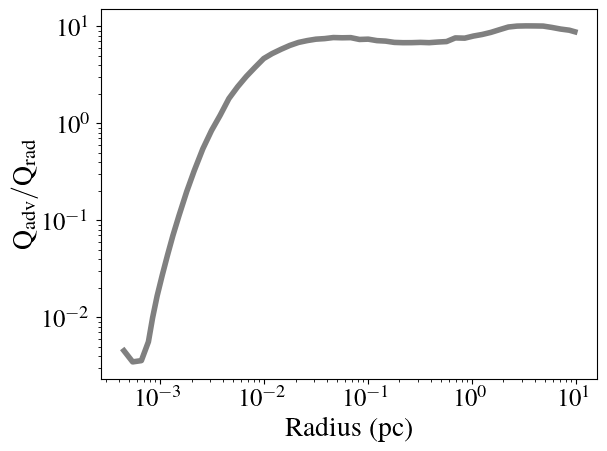

In [11]:
from plot_cooling_rates import moving_average, interpolate_data, extract_colors

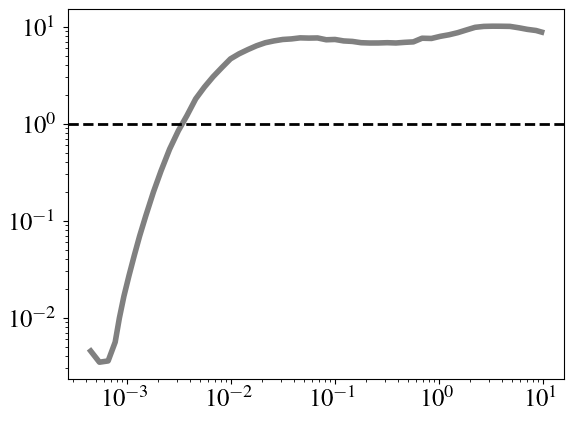

In [12]:
data_beck = pd.read_csv("cooling_line_beckmann.csv")
radius_beck = data_beck['radius'].tolist()
q_ratio_beck = data_beck['qratio'].tolist()
plt.loglog(radius_beck, q_ratio_beck, color="grey", label="Beckmann_2018",linewidth=4)
plt.axhline(y=1, color='k', linestyle='--', label="q=1")

In [ ]:
# my data 
root_dir = ["/disk14/sgordon/cirrus-runs-rsync/seed1-bh-only/270msun/replicating-beckmann",
    "/disk14/sgordon/cirrus-runs-rsync/seed1-bh-only/270msun/replicating-beckmann", 
    "/Backup00/sgordon/pleiades/seed1-bh-only/seed1-bh-only/270msun/replicating-beckmann",
    "/Backup00/sgordon/pleiades/seed2-bh-only/270msun/replicating-beckmann-2",
    "/Backup00/sgordon/pleiades/seed2-bh-only/270msun/replicating-beckmann-2"]
sim = [
"1B.RSb01-2", 
"1B.RSb16",
"1B.m16-4dx",
"2B.RSb08/2B.RSb08-2",
"2B.m08-4dx/2B.m16-4dx-2",
#"2B.m08-4dx"
] 
dds = [
"DD0138/DD0138", # 1 Myr
"DD0166/DD0166", # 1 Myr
"DD0202/DD0202", # 1.000 Myr
"DD0279/DD0279", # 1 Myr
#"DD0299/DD0299", # 1 Myr in 2B.m08-4dx
    "DD0304/DD0304"
    ] # 1 Myr in 2B.m16-4dx
j=0
ds = yt.load(os.path.join(root_dir[j], sim[j], dds[j]))

yt : [INFO     ] 2023-12-13 12:29:10,075 Parameters: current_time              = 14.046261369306
yt : [INFO     ] 2023-12-13 12:29:10,076 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-12-13 12:29:10,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-13 12:29:10,079 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-12-13 12:29:10,080 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-12-13 12:29:10,081 Parameters: current_redshift          = 26.160651601036
yt : [INFO     ] 2023-12-13 12:29:10,082 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-12-13 12:29:10,083 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-12-13 12:29:10,084 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-12-13 12:29:10,086 Parameters: hubble_constant           = 0.71


In [13]:
add_fields_ds(ds)
    
# make profile from disk object
ss_pos, ss_mass, ss_age = ss_properties(ds)
disk, L = _make_disk_L(ds, ss_pos, 10*yt.units.pc, 0.2*yt.units.pc)
profile = yt.create_profile(
data_source=disk,
bin_fields=[("index", "radius")],
fields=[("enzo", "radiative_cooling_rate"), ("enzo", "advective_cooling_rate")],
n_bins=512,
units=dict(radius="pc"),
logs=dict(radius=True),
weight_field=("gas", "mass"),
    )

Parsing Hierarchy : 100%|██████████| 2257/2257 [00:00<00:00, 5163.04it/s]
/home/sgordon/.local/lib/python3.10/site-packages/unyt/array.py:1906: RuntimeWarning: divide by zero encountered in divide
  out_arr = func(


ds =  DD0138


Text(0, 0.5, 'q ratio')

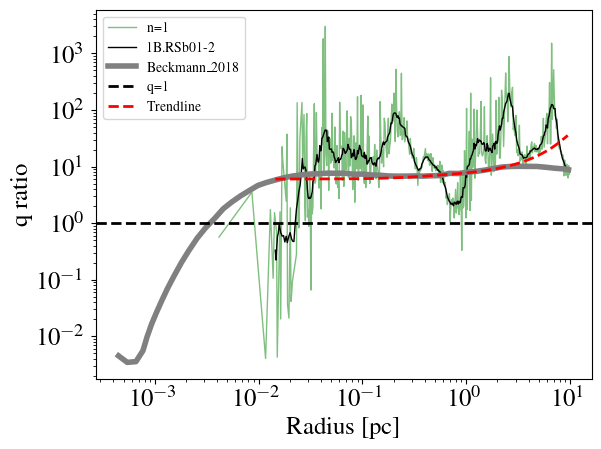

In [78]:
def adaptive_moving_average(data, window_size=5):
    """
    Compute an adaptive moving average on the logarithm of the data.
    
    :param data: The input data (list or array).
    :param window_size: The window size for the moving average.
    :return: An array of the moving average values in the original data space.
    """
    # Take the logarithm of data, excluding non-positive values
    log_data = np.log(data[data > 0])
    data_length = len(log_data)
    log_moving_avg = np.zeros(data_length)

    for i in range(data_length):
        start = max(i - window_size // 2, 0)
        end = min(i + window_size // 2 + 1, data_length)
        log_moving_avg[i] = np.mean(log_data[start:end])

    # Exponentiate to return to original data space
    moving_avg = np.exp(log_moving_avg)

    # Handle edge cases if original data had non-positive values
    moving_avg_full = np.full_like(data, np.nan)
    positive_indices = np.where(data > 0)[0]
    moving_avg_full[positive_indices] = moving_avg

    return moving_avg_full

def moving_variance(data, window_size=5):
    """Estimate the variance using a moving window approach."""
    n = len(data)
    variance = np.full(n, np.nan)
    
    for i in range(n):
        start = max(i - window_size // 2, 0)
        end = min(i + window_size // 2 + 1, n)
        window_data = data[start:end]
        
        # Calculate the variance within the window
        if len(window_data) > 1:  # We need at least two points to calculate a variance
            variance[i] = np.var(window_data, ddof=1)  # ddof=1 provides an unbiased estimator

    return variance


n = 10
cooling_ratio = np.abs(profile[("enzo", "radiative_cooling_rate")][profile.used]/profile[("enzo", "advective_cooling_rate")][profile.used])
dx = ds.index.get_smallest_dx().to("pc")
mask = profile.x[profile.used] >= dx
truncated_radius_values = profile.x[profile.used][mask]
x_avg = adaptive_moving_average(truncated_radius_values, window_size=n)
y_avg = adaptive_moving_average(cooling_ratio[mask], window_size=n)
# Append the data to the aggregated lists
all_x = []
all_y = []
all_x.append(x_avg)
all_y.append(y_avg)
fig, axs = plt.subplots(1, sharex=True)
plt.loglog(adaptive_moving_average(profile.x[profile.used], window_size=1), adaptive_moving_average(cooling_ratio, window_size=1), color="green", label="n=1",linewidth=1, alpha=0.5)
plt.loglog(x_avg, y_avg, color="k", label="1B.RSb01-2",linewidth=1)
plt.loglog(radius_beck, q_ratio_beck, color="grey", label="Beckmann_2018",linewidth=4)
plt.axhline(y=1, color='k', linestyle='--', label="q=1")

# After the loop, compute the trendline for the aggregated data
# Filter out any zero or negative values since log of zero or negative is undefined
x_values = all_x[0].d
y_values = all_y[0].d
positive_mask = (x_values > 0) & (y_values > 0)
x_values = x_values[positive_mask]
y_values = y_values[positive_mask]
# Log-transform x and y values
log_x = np.log10(x_values)
log_y = np.log10(y_values)
# Fit a linear model to the log-transformed data
coefficients = np.polyfit(log_x, log_y, 1)
# Create a power-law function based on the coefficients
def power_law(x, a, b):
    return a * np.power(x, b)
# Use the coefficients to create the trendline
trendline = power_law(x_values, 10**coefficients[1], coefficients[0])

# from scipy.optimize import curve_fit

# # Define a more complex model if needed
# def complex_model(x, a, b, c, d):
#     return a * np.power(x, b) + c * np.log(x) + d

# # Perform the curve fitting with weights (if available)
# variance = moving_variance(y_values, window_size=n)
# weights = 1 / np.sqrt(variance)  # Replace 'variance' with your actual variance array
# popt, pcov = curve_fit(power_law, x_values, y_values, sigma=weights)  # , sigma=weights

# # Use the optimal parameters to create the trendline
# trendline = power_law(x_values, *popt)

# Create a range of x values for plotting the trendline
trend_x = np.linspace(min(x_values), max(x_values), 412)
trend_y = trendline
plt.plot(trend_x, trend_y, linestyle="--", color='red', label='Trendline')
plt.legend(loc="upper left", fontsize=10)
plt.xlabel("Radius [pc]")
plt.ylabel("q ratio")

In [80]:
len(all_y[0])

412

In [5]:
def calculate_theta_array(dimensions):
    """
    Calculate the theta array for a given set of dimensions.
    Input:
        dimensions: tuple of dimensions for the array
    Output:
        theta_array: 2D array of theta values for each pixel in the array
    """
    # Create an empty array of the same dimensions
    theta_array = np.zeros(dimensions)

    # Calculate the center of the array
    center_x, center_y = dimensions[0] // 2, dimensions[1] // 2

    # Iterate over each pixel
    for x in range(dimensions[0]):
        for y in range(dimensions[1]):
            # Calculate the relative positions
            rel_x, rel_y = x - center_x, y - center_y

            # Calculate the angle and adjust to ensure 0 is 'north'
            theta = np.arctan2(rel_y, rel_x) + np.pi / 2

            # Normalize the angle to be between 0 and 2pi
            theta = theta % (2 * np.pi)

            # Assign the calculated theta to the array
            theta_array[x, y] = theta

    return theta_array
dimensions = (2048,2048)
theta = calculate_theta_array(dimensions)

In [13]:
np.where(theta == np.pi/2)

(array([1024, 1025, 1026, ..., 2045, 2046, 2047]),
 array([1024, 1024, 1024, ..., 1024, 1024, 1024]))

In [24]:
def tidy_data_labels(labels, custom_name=None):
    if custom_name:
        return custom_name
    # for lists of labels
    elif len(labels) < 5:
        data_labels = [i.replace("-2", "") for i in labels]
        data_labels = [i.replace("RS", "") for i in data_labels]
        data_labels = [i.replace("-4dx", "") for i in data_labels]
    # for single label
    else:
        print("here")
        data_labels = labels.replace("-2", "")
        data_labels = labels.replace("RS", "")
        data_labels = labels.replace("-4dx", "")
        if not isinstance(data_labels, str):
            print("sim_name = ", data_labels)
            raise TypeError("sim_name is not a string - try add / to end of directory path")
    return data_labels

In [26]:
def tidy_data_labels(labels, custom_name=None):
    if custom_name:
        return custom_name
    
    # Function to apply replacements to a single label
    def apply_replacements(label):
        label = label.replace("-2", "")
        label = label.replace("RS", "")
        label = label.replace("-4dx", "")
        return label

    # Check if labels is a list or a single label
    if isinstance(labels, list):
        # Process each label in the list
        data_labels = [apply_replacements(label) for label in labels]
    elif isinstance(labels, str):
        # Process a single label
        data_labels = apply_replacements(labels)
    else:
        raise TypeError("labels should be a string or a list of strings")

    return data_labels


In [28]:
labels = ["1B.RSb01", "2B.RSm01-4dx"]
tidy_data_labels(labels)

['1B.b01', '2B.m01']

In [14]:
path = "/Backup00/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/1B.m16-4dx/DD0221/DD0221"
ds = yt.load(path)

yt : [INFO     ] 2023-12-11 15:17:05,879 Parameters: current_time              = 14.036208228193
yt : [INFO     ] 2023-12-11 15:17:05,883 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-12-11 15:17:05,884 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-11 15:17:05,893 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-12-11 15:17:05,894 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-12-11 15:17:05,895 Parameters: current_redshift          = 26.173619486418
yt : [INFO     ] 2023-12-11 15:17:05,896 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-12-11 15:17:05,897 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-12-11 15:17:05,899 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-12-11 15:17:05,900 Parameters: hubble_constant           = 0.71


In [22]:

from yt.utilities.math_utils import ortho_find
def _make_disk_L(ds, center, width_pc, height_pc):
    width = width_pc*yt.units.pc
    height = height_pc*yt.units.pc
    sp = ds.sphere(center, width)
    L = sp.quantities.angular_momentum_vector()
    L /= np.sqrt((L ** 2).sum()) # normal vector is N = L/|L|
    disk = ds.disk(center, L, width, height)
    return disk, L
disc_h_pc = disc_r_pc = 0.01
center = ds.domain_center
_, L = _make_disk_L(ds, center, disc_r_pc, disc_h_pc)
vecs = ortho_find(L)
dir = vecs[0]
north = vecs[1]
disc_r_pc_big = disc_h_pc_big = 0.01 # pc
disk = ds.disk(center, L, disc_r_pc_big, disc_h_pc_big)

In [19]:
disk['velocity_cylindrical_theta'].to('cm/s')

unyt_array([-164303.99372257, -160420.47043055, -147667.73550356, ...,
             202693.53324487,  201705.98712442,  200805.44390654], 'cm/s')

In [24]:
from plot_toomre_q_projection import field_from_sliceplot
npixels = 200
width_pc = 0.01
cylindrical_velocity_theta = field_from_sliceplot("velocity_cylindrical_theta", ds, disk, center, width_pc, north, dir, npixels=npixels, radius=False)


yt : [INFO     ] 2023-12-11 15:31:57,289 xlim = -0.000000 0.000000
yt : [INFO     ] 2023-12-11 15:31:57,291 ylim = -0.000000 0.000000
yt : [INFO     ] 2023-12-11 15:31:57,292 Making a fixed resolution buffer of (('gas', 'velocity_cylindrical_theta')) 800 by 800
yt : [INFO     ] 2023-12-11 15:31:57,754 Making a fixed resolution buffer of (('gas', 'velocity_cylindrical_theta')) 200 by 200


ImageArray([[92092.12857595, 92092.12857595, 92092.12857595, ...,
             92092.12857595, 92092.12857595, 92092.12857595],
            [92092.12857595, 92092.12857595, 92092.12857595, ...,
             92092.12857595, 92092.12857595, 92092.12857595],
            [92092.12857595, 92092.12857595, 92092.12857595, ...,
             92092.12857595, 92092.12857595, 92092.12857595],
            ...,
            [92092.12857595, 92092.12857595, 92092.12857595, ...,
             92092.12857595, 92092.12857595, 92092.12857595],
            [92092.12857595, 92092.12857595, 92092.12857595, ...,
             92092.12857595, 92092.12857595, 92092.12857595],
            [92092.12857595, 92092.12857595, 92092.12857595, ...,
             92092.12857595, 92092.12857595, 92092.12857595]], 'cm/s')

In [27]:
cylindrical_velocity_theta[0]

ImageArray([92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.12857595, 92092.12857595,
            92092.12857595, 92092.128575

In [17]:
width_pc_list = [0.05, 0.1, 0.2, 0.3] # fill this with corresponding width_pc values
width_pc_list = [0.1]

# load data
# Get a list of directories matching the pattern DD0*
dir_pattern = "/Backup00/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/1B.m16-4dx/DD0*"
dir_pattern = "/ceph/cephfs/sgordon/pleiades/seed2-bh-only/270msun/replicating-beckmann-2/2B.RSb08/2B.RSb08-2/DD0*"
dirs = glob.glob(dir_pattern)

# Filter out directories such that only those which have a child file with the same name are retained
filtered_dirs = [d for d in dirs if os.path.exists(os.path.join(d, os.path.basename(d)))]

# Construct the full path to the desired files
files_to_load = [os.path.join(d, os.path.basename(d)) for d in filtered_dirs]
files_to_load.sort(key=extract_dd_number)
ds_list = yt.DatasetSeries(files_to_load)[60:82]
ds_list

In [18]:
len(files_to_load)

85

yt : [INFO     ] 2023-10-26 13:46:07,073 Parameters: current_time              = 21.934930978113
yt : [INFO     ] 2023-10-26 13:46:07,074 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 13:46:07,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 13:46:07,076 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 13:46:07,077 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 13:46:07,078 Parameters: current_redshift          = 19.178100751877
yt : [INFO     ] 2023-10-26 13:46:07,079 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 13:46:07,080 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 13:46:07,081 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 13:46:07,082 Parameters: hubble_constant           = 0.71


ds =  DD0259


Parsing Hierarchy : 100%|██████████| 5858/5858 [00:01<00:00, 3442.60it/s]
yt : [INFO     ] 2023-10-26 13:46:08,966 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 13:53:05,077 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 13:53:05,119 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 13:53:05,153 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 13:53:06,357 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 13:53:06,885 Making a fixed resolution buffer of (radius) 2048 by 2048


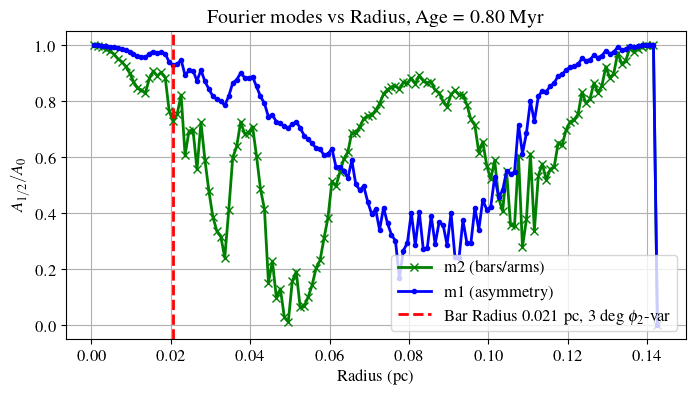

yt : [INFO     ] 2023-10-26 13:53:22,721 Parameters: current_time              = 21.936047882113
yt : [INFO     ] 2023-10-26 13:53:22,723 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 13:53:22,724 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 13:53:22,725 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 13:53:22,726 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 13:53:22,726 Parameters: current_redshift          = 19.177415739728
yt : [INFO     ] 2023-10-26 13:53:22,727 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 13:53:22,728 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 13:53:22,729 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 13:53:22,730 Parameters: hubble_constant           = 0.71


DD: DD0259, age: 0.80 Myr, m2 mean: 0.6638, m2 var: 0.2612, m1_avg: 0.7137, m1_var: 0.2556, Bar radius: 0.0206, Bar strength: 0.9124, m1 in bar region: 0.9775, phi_2_mean: -7.2780 deg, phi_2_var: 51.76265 deg 

ds =  DD0260


Parsing Hierarchy : 100%|██████████| 5986/5986 [00:00<00:00, 9999.67it/s] 
yt : [INFO     ] 2023-10-26 13:53:23,578 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:00:00,459 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:00:00,500 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:00:00,507 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:00:01,503 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:00:01,967 Making a fixed resolution buffer of (radius) 2048 by 2048


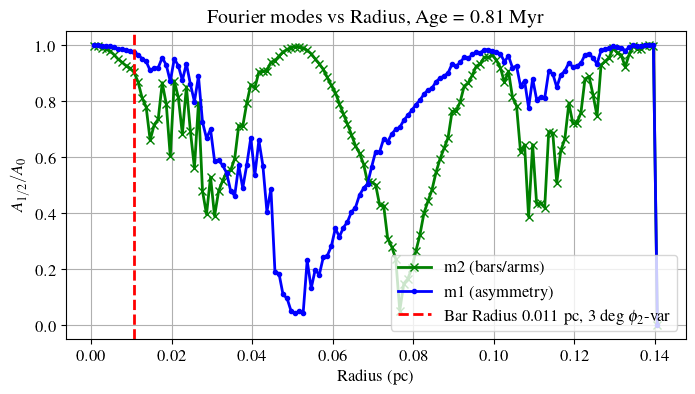

yt : [INFO     ] 2023-10-26 14:00:13,424 Parameters: current_time              = 21.937164786113
yt : [INFO     ] 2023-10-26 14:00:13,425 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:00:13,426 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:00:13,427 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:00:13,428 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:00:13,429 Parameters: current_redshift          = 19.176730785709
yt : [INFO     ] 2023-10-26 14:00:13,430 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:00:13,431 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:00:13,431 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:00:13,432 Parameters: hubble_constant           = 0.71


DD: DD0260, age: 0.81 Myr, m2 mean: 0.7398, m2 var: 0.2333, m1_avg: 0.7427, m1_var: 0.2808, Bar radius: 0.0106, Bar strength: 0.9648, m1 in bar region: 0.9911, phi_2_mean: 4.5512 deg, phi_2_var: 50.29316 deg 

ds =  DD0261


Parsing Hierarchy : 100%|██████████| 6070/6070 [00:00<00:00, 16679.92it/s]
yt : [INFO     ] 2023-10-26 14:00:15,548 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:09:05,364 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:09:05,394 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:09:05,402 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:09:06,420 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:09:06,774 Making a fixed resolution buffer of (radius) 2048 by 2048


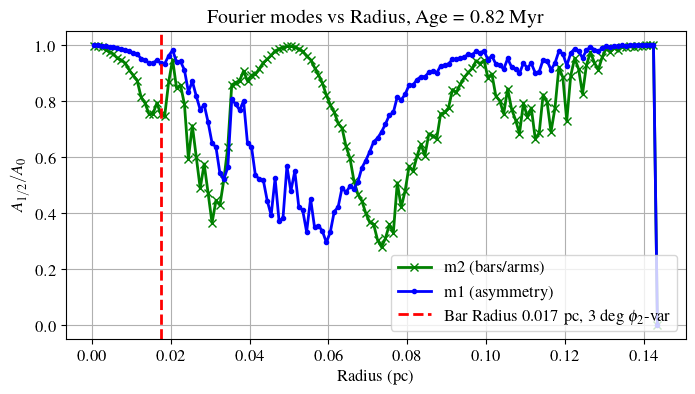

yt : [INFO     ] 2023-10-26 14:09:13,555 Parameters: current_time              = 21.938281690113
yt : [INFO     ] 2023-10-26 14:09:13,556 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:09:13,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:09:13,558 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:09:13,559 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:09:13,560 Parameters: current_redshift          = 19.176045889813
yt : [INFO     ] 2023-10-26 14:09:13,561 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:09:13,561 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:09:13,562 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:09:13,563 Parameters: hubble_constant           = 0.71


DD: DD0261, age: 0.82 Myr, m2 mean: 0.7844, m2 var: 0.2024, m1_avg: 0.8023, m1_var: 0.2209, Bar radius: 0.0175, Bar strength: 0.9018, m1 in bar region: 0.9746, phi_2_mean: 3.3968 deg, phi_2_var: 48.01208 deg 

ds =  DD0262


Parsing Hierarchy : 100%|██████████| 6026/6026 [00:00<00:00, 15985.08it/s]
yt : [INFO     ] 2023-10-26 14:09:14,123 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:18:26,908 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:18:26,912 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:18:26,918 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:18:27,932 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:18:28,248 Making a fixed resolution buffer of (radius) 2048 by 2048


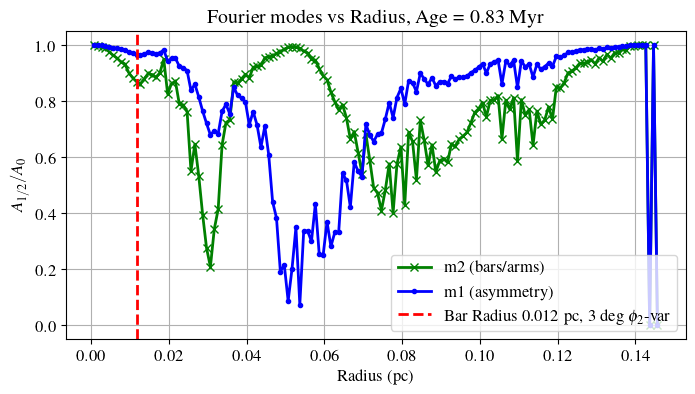

yt : [INFO     ] 2023-10-26 14:18:35,049 Parameters: current_time              = 21.939398594113
yt : [INFO     ] 2023-10-26 14:18:35,050 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:18:35,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:18:35,051 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:18:35,052 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:18:35,052 Parameters: current_redshift          = 19.175361052032
yt : [INFO     ] 2023-10-26 14:18:35,053 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:18:35,053 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:18:35,054 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:18:35,054 Parameters: hubble_constant           = 0.71


DD: DD0262, age: 0.83 Myr, m2 mean: 0.7807, m2 var: 0.1989, m1_avg: 0.7897, m1_var: 0.2472, Bar radius: 0.0117, Bar strength: 0.9569, m1 in bar region: 0.9890, phi_2_mean: -3.7923 deg, phi_2_var: 46.16263 deg 

ds =  DD0263


Parsing Hierarchy : 100%|██████████| 6047/6047 [00:00<00:00, 13489.15it/s]
yt : [INFO     ] 2023-10-26 14:18:35,712 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:27:00,540 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:27:00,542 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:27:00,567 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:27:01,555 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:27:01,988 Making a fixed resolution buffer of (radius) 2048 by 2048


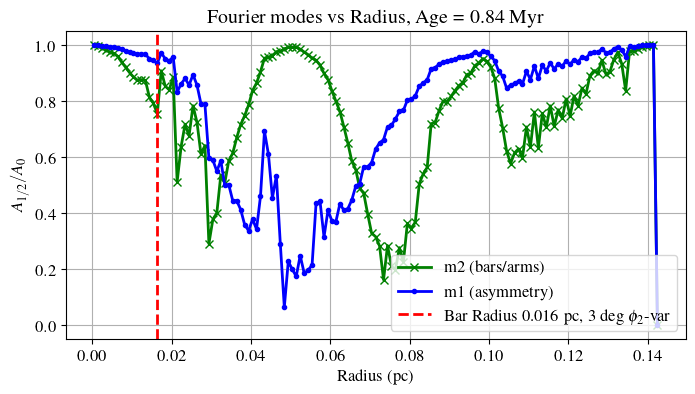

yt : [INFO     ] 2023-10-26 14:27:19,059 Parameters: current_time              = 21.940515498113
yt : [INFO     ] 2023-10-26 14:27:19,061 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:27:19,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:27:19,063 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:27:19,064 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:27:19,064 Parameters: current_redshift          = 19.174676272358
yt : [INFO     ] 2023-10-26 14:27:19,065 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:27:19,066 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:27:19,067 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:27:19,067 Parameters: hubble_constant           = 0.71


DD: DD0263, age: 0.84 Myr, m2 mean: 0.7539, m2 var: 0.2219, m1_avg: 0.7624, m1_var: 0.2593, Bar radius: 0.0164, Bar strength: 0.9220, m1 in bar region: 0.9799, phi_2_mean: 3.8010 deg, phi_2_var: 50.54970 deg 

ds =  DD0264


Parsing Hierarchy : 100%|██████████| 6080/6080 [00:02<00:00, 2525.26it/s]
yt : [INFO     ] 2023-10-26 14:27:21,713 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:35:37,404 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:35:37,425 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:35:37,433 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:35:38,446 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:35:38,981 Making a fixed resolution buffer of (radius) 2048 by 2048


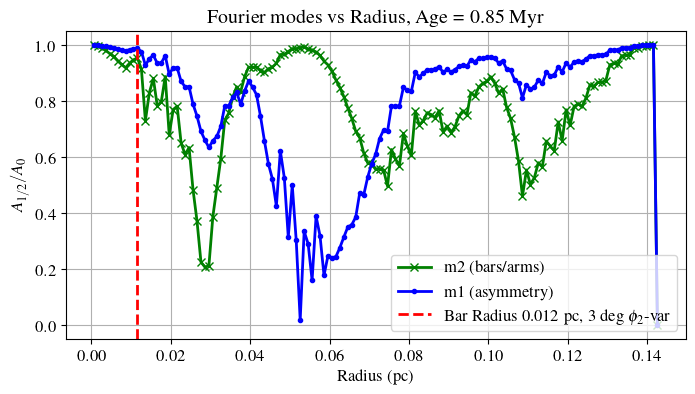

yt : [INFO     ] 2023-10-26 14:35:50,871 Parameters: current_time              = 21.941632402113
yt : [INFO     ] 2023-10-26 14:35:50,872 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:35:50,873 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:35:50,874 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:35:50,874 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:35:50,875 Parameters: current_redshift          = 19.173991550784
yt : [INFO     ] 2023-10-26 14:35:50,875 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:35:50,876 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:35:50,877 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:35:50,877 Parameters: hubble_constant           = 0.71


DD: DD0264, age: 0.85 Myr, m2 mean: 0.7767, m2 var: 0.1855, m1_avg: 0.7865, m1_var: 0.2401, Bar radius: 0.0116, Bar strength: 0.9606, m1 in bar region: 0.9900, phi_2_mean: -1.4531 deg, phi_2_var: 48.97521 deg 

ds =  DD0265


Parsing Hierarchy : 100%|██████████| 6123/6123 [00:00<00:00, 10040.63it/s]
yt : [INFO     ] 2023-10-26 14:35:51,675 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:42:43,739 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:42:43,768 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:42:43,776 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:42:44,755 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:42:45,562 Making a fixed resolution buffer of (radius) 2048 by 2048


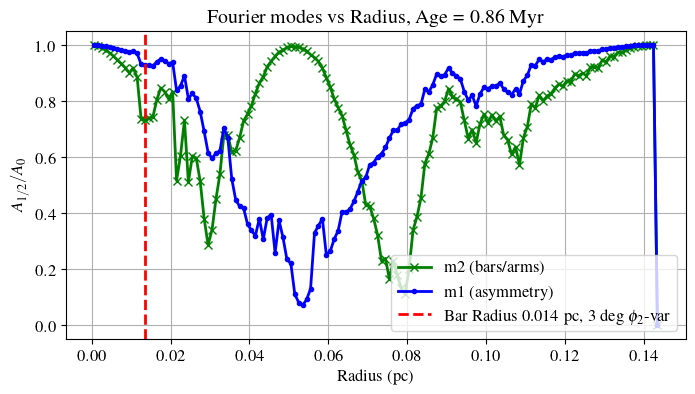

yt : [INFO     ] 2023-10-26 14:43:03,635 Parameters: current_time              = 21.942749306113
yt : [INFO     ] 2023-10-26 14:43:03,636 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:43:03,637 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:43:03,638 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:43:03,639 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:43:03,640 Parameters: current_redshift          = 19.1733068873
yt : [INFO     ] 2023-10-26 14:43:03,641 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:43:03,642 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:43:03,643 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:43:03,643 Parameters: hubble_constant           = 0.71


DD: DD0265, age: 0.86 Myr, m2 mean: 0.7416, m2 var: 0.2298, m1_avg: 0.7359, m1_var: 0.2690, Bar radius: 0.0135, Bar strength: 0.9338, m1 in bar region: 0.9830, phi_2_mean: -2.4911 deg, phi_2_var: 50.46550 deg 

ds =  DD0266


Parsing Hierarchy : 100%|██████████| 6033/6033 [00:00<00:00, 12203.87it/s]
yt : [INFO     ] 2023-10-26 14:43:04,366 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 14:54:33,588 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:54:33,624 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 14:54:33,632 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 14:54:34,566 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 14:54:36,651 Making a fixed resolution buffer of (radius) 2048 by 2048


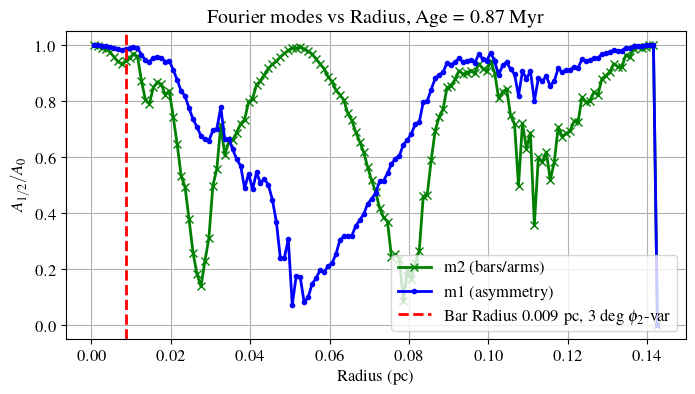

yt : [INFO     ] 2023-10-26 14:54:55,417 Parameters: current_time              = 21.943866210113
yt : [INFO     ] 2023-10-26 14:54:55,418 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 14:54:55,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 14:54:55,420 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 14:54:55,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 14:54:55,422 Parameters: current_redshift          = 19.1726222819
yt : [INFO     ] 2023-10-26 14:54:55,423 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 14:54:55,423 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 14:54:55,424 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 14:54:55,425 Parameters: hubble_constant           = 0.71


DD: DD0266, age: 0.87 Myr, m2 mean: 0.7377, m2 var: 0.2403, m1_avg: 0.7331, m1_var: 0.2765, Bar radius: 0.0086, Bar strength: 0.9723, m1 in bar region: 0.9930, phi_2_mean: -8.9959 deg, phi_2_var: 49.89465 deg 

ds =  DD0267


Parsing Hierarchy : 100%|██████████| 5878/5878 [00:03<00:00, 1720.49it/s]
yt : [INFO     ] 2023-10-26 14:54:59,027 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 15:04:45,874 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:04:45,878 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:04:45,885 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 15:04:46,869 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 15:04:47,558 Making a fixed resolution buffer of (radius) 2048 by 2048


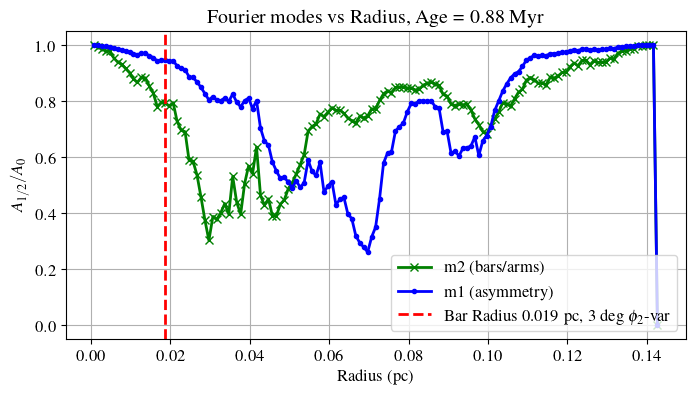

yt : [INFO     ] 2023-10-26 15:05:21,577 Parameters: current_time              = 21.944983114113
yt : [INFO     ] 2023-10-26 15:05:21,578 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 15:05:21,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 15:05:21,580 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 15:05:21,581 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 15:05:21,582 Parameters: current_redshift          = 19.171937734575
yt : [INFO     ] 2023-10-26 15:05:21,583 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 15:05:21,583 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 15:05:21,584 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 15:05:21,585 Parameters: hubble_constant           = 0.71


DD: DD0267, age: 0.88 Myr, m2 mean: 0.7622, m2 var: 0.1870, m1_avg: 0.7794, m1_var: 0.2126, Bar radius: 0.0187, Bar strength: 0.9081, m1 in bar region: 0.9764, phi_2_mean: 36.8293 deg, phi_2_var: 46.38824 deg 

ds =  DD0268


Parsing Hierarchy : 100%|██████████| 5952/5952 [00:00<00:00, 13793.39it/s]
yt : [INFO     ] 2023-10-26 15:05:22,182 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 15:15:32,219 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:15:32,254 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:15:32,261 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 15:15:33,342 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 15:15:33,918 Making a fixed resolution buffer of (radius) 2048 by 2048


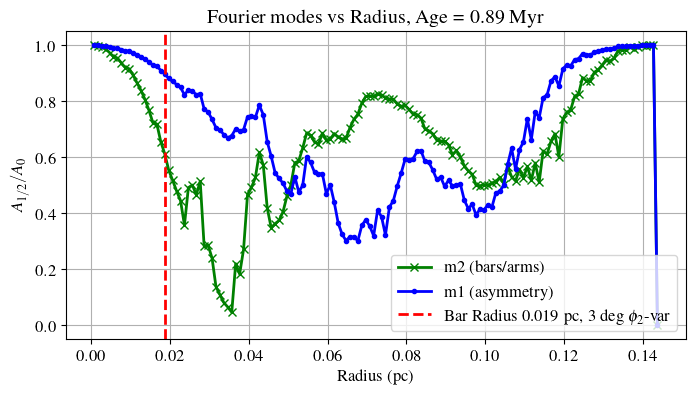

yt : [INFO     ] 2023-10-26 15:15:58,458 Parameters: current_time              = 21.946100018113
yt : [INFO     ] 2023-10-26 15:15:58,460 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 15:15:58,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 15:15:58,462 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 15:15:58,463 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 15:15:58,463 Parameters: current_redshift          = 19.171253245317
yt : [INFO     ] 2023-10-26 15:15:58,464 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 15:15:58,465 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 15:15:58,466 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 15:15:58,466 Parameters: hubble_constant           = 0.71


DD: DD0268, age: 0.89 Myr, m2 mean: 0.6570, m2 var: 0.2289, m1_avg: 0.6951, m1_var: 0.2312, Bar radius: 0.0187, Bar strength: 0.8827, m1 in bar region: 0.9696, phi_2_mean: 27.7658 deg, phi_2_var: 46.29282 deg 

ds =  DD0269


Parsing Hierarchy : 100%|██████████| 5812/5812 [00:00<00:00, 12642.19it/s]
yt : [INFO     ] 2023-10-26 15:15:59,101 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 15:26:37,648 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:26:37,652 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:26:37,659 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 15:26:38,650 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 15:26:39,191 Making a fixed resolution buffer of (radius) 2048 by 2048


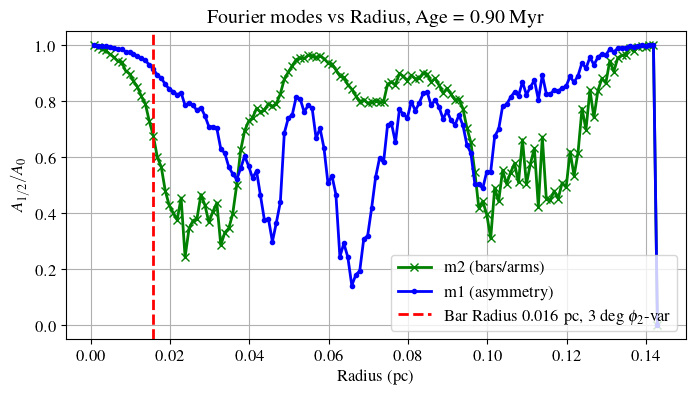

yt : [INFO     ] 2023-10-26 15:27:06,127 Parameters: current_time              = 21.947216922113
yt : [INFO     ] 2023-10-26 15:27:06,128 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 15:27:06,129 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 15:27:06,130 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 15:27:06,131 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 15:27:06,132 Parameters: current_redshift          = 19.17056881412
yt : [INFO     ] 2023-10-26 15:27:06,133 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 15:27:06,134 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 15:27:06,134 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 15:27:06,135 Parameters: hubble_constant           = 0.71


DD: DD0269, age: 0.90 Myr, m2 mean: 0.7262, m2 var: 0.2183, m1_avg: 0.7390, m1_var: 0.2158, Bar radius: 0.0158, Bar strength: 0.9085, m1 in bar region: 0.9764, phi_2_mean: 22.7764 deg, phi_2_var: 46.70641 deg 

ds =  DD0270


Parsing Hierarchy : 100%|██████████| 5855/5855 [00:00<00:00, 14001.13it/s]
yt : [INFO     ] 2023-10-26 15:27:06,803 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 15:36:59,657 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:36:59,660 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:36:59,663 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 15:37:00,636 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 15:37:01,389 Making a fixed resolution buffer of (radius) 2048 by 2048


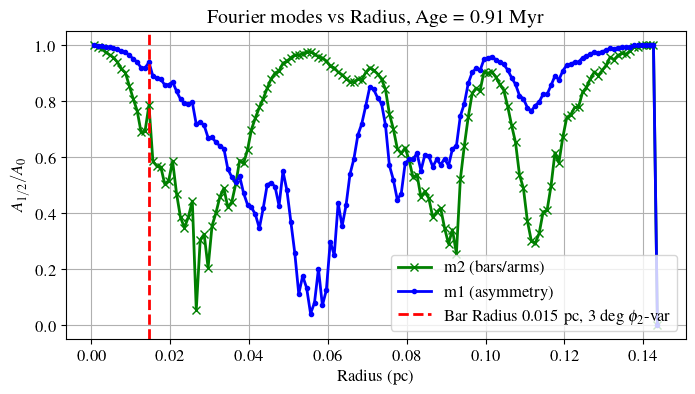

yt : [INFO     ] 2023-10-26 15:37:42,044 Parameters: current_time              = 21.948333826113
yt : [INFO     ] 2023-10-26 15:37:42,045 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 15:37:42,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 15:37:42,046 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 15:37:42,047 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 15:37:42,047 Parameters: current_redshift          = 19.169884440974
yt : [INFO     ] 2023-10-26 15:37:42,047 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 15:37:42,048 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 15:37:42,048 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 15:37:42,048 Parameters: hubble_constant           = 0.71


DD: DD0270, age: 0.91 Myr, m2 mean: 0.7146, m2 var: 0.2393, m1_avg: 0.7192, m1_var: 0.2556, Bar radius: 0.0146, Bar strength: 0.8884, m1 in bar region: 0.9711, phi_2_mean: -15.6057 deg, phi_2_var: 50.96545 deg 

ds =  DD0271


Parsing Hierarchy : 100%|██████████| 5904/5904 [00:02<00:00, 2029.26it/s]
yt : [INFO     ] 2023-10-26 15:37:45,131 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 15:45:18,938 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:45:18,944 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:45:18,951 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 15:45:19,875 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 15:45:20,584 Making a fixed resolution buffer of (radius) 2048 by 2048


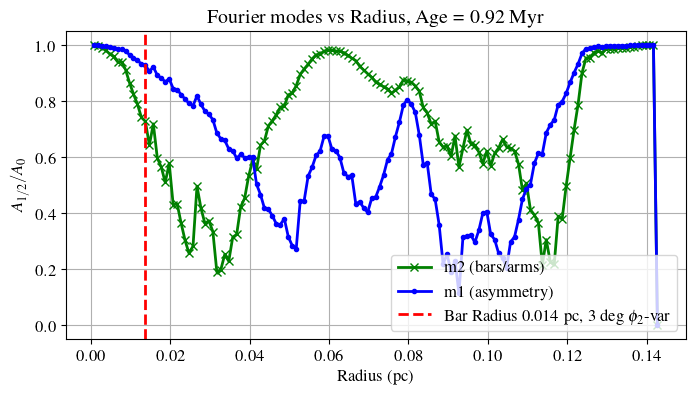

yt : [INFO     ] 2023-10-26 15:45:52,086 Parameters: current_time              = 21.949450730113
yt : [INFO     ] 2023-10-26 15:45:52,087 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 15:45:52,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 15:45:52,089 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 15:45:52,090 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 15:45:52,091 Parameters: current_redshift          = 19.169200125872
yt : [INFO     ] 2023-10-26 15:45:52,091 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 15:45:52,092 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 15:45:52,093 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 15:45:52,094 Parameters: hubble_constant           = 0.71


DD: DD0271, age: 0.92 Myr, m2 mean: 0.7087, m2 var: 0.2456, m1_avg: 0.6556, m1_var: 0.2577, Bar radius: 0.0137, Bar strength: 0.9158, m1 in bar region: 0.9783, phi_2_mean: -13.3172 deg, phi_2_var: 61.42560 deg 

ds =  DD0272


Parsing Hierarchy : 100%|██████████| 5886/5886 [00:00<00:00, 13952.84it/s]
yt : [INFO     ] 2023-10-26 15:45:52,768 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 15:54:15,969 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:54:15,972 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 15:54:15,980 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 15:54:17,044 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 15:54:17,604 Making a fixed resolution buffer of (radius) 2048 by 2048


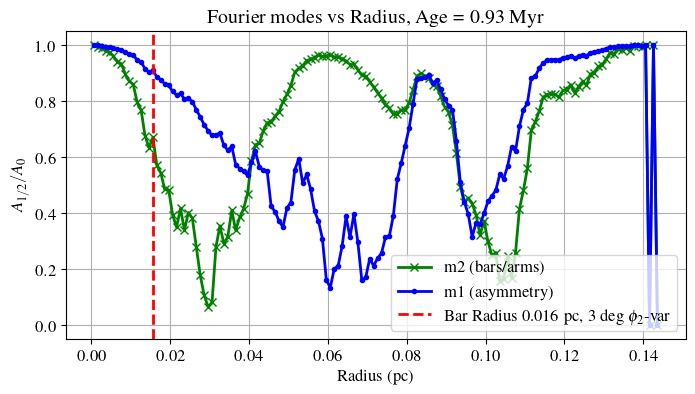

yt : [INFO     ] 2023-10-26 15:54:42,123 Parameters: current_time              = 21.950567634113
yt : [INFO     ] 2023-10-26 15:54:42,124 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 15:54:42,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 15:54:42,126 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 15:54:42,127 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 15:54:42,128 Parameters: current_redshift          = 19.168515868806
yt : [INFO     ] 2023-10-26 15:54:42,129 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 15:54:42,129 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 15:54:42,130 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 15:54:42,131 Parameters: hubble_constant           = 0.71


DD: DD0272, age: 0.93 Myr, m2 mean: 0.6977, m2 var: 0.2707, m1_avg: 0.6827, m1_var: 0.2711, Bar radius: 0.0156, Bar strength: 0.8843, m1 in bar region: 0.9700, phi_2_mean: -23.6358 deg, phi_2_var: 52.53704 deg 

ds =  DD0273


Parsing Hierarchy : 100%|██████████| 5877/5877 [00:00<00:00, 17260.84it/s]
yt : [INFO     ] 2023-10-26 15:54:42,626 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:00:34,541 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:00:34,546 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:00:34,558 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:00:35,477 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:00:36,082 Making a fixed resolution buffer of (radius) 2048 by 2048


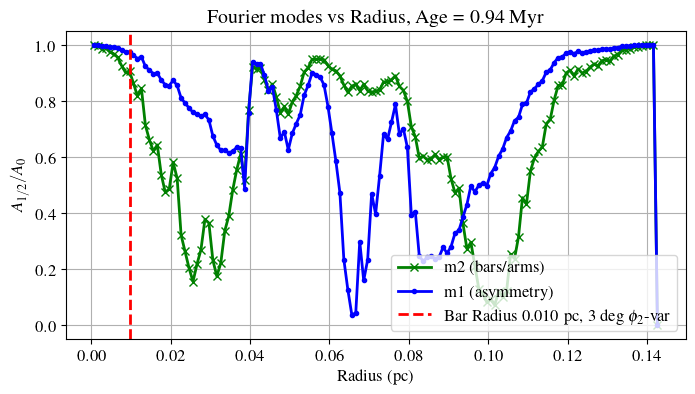

yt : [INFO     ] 2023-10-26 16:01:04,952 Parameters: current_time              = 21.951684538113
yt : [INFO     ] 2023-10-26 16:01:04,954 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:01:04,956 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:01:04,957 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:01:04,958 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:01:04,959 Parameters: current_redshift          = 19.167831669769
yt : [INFO     ] 2023-10-26 16:01:04,960 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:01:04,961 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:01:04,962 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:01:04,963 Parameters: hubble_constant           = 0.71


DD: DD0273, age: 0.94 Myr, m2 mean: 0.6852, m2 var: 0.2800, m1_avg: 0.7210, m1_var: 0.2601, Bar radius: 0.0096, Bar strength: 0.9665, m1 in bar region: 0.9915, phi_2_mean: -3.7075 deg, phi_2_var: 56.79354 deg 

ds =  DD0274


Parsing Hierarchy : 100%|██████████| 5921/5921 [00:00<00:00, 13937.54it/s]
yt : [INFO     ] 2023-10-26 16:01:05,570 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:09:47,338 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:09:47,344 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:09:47,352 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:09:48,458 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:09:48,924 Making a fixed resolution buffer of (radius) 2048 by 2048


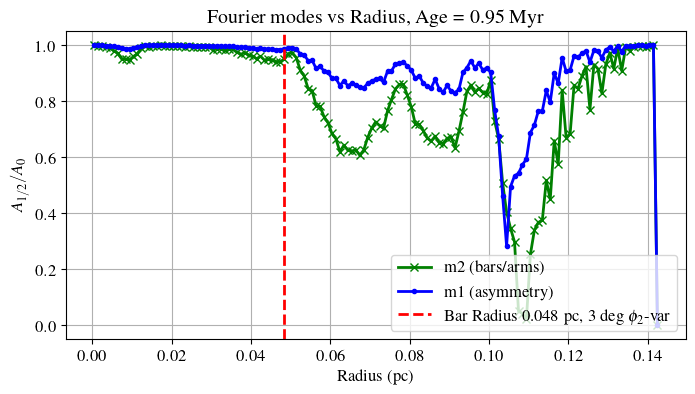

yt : [INFO     ] 2023-10-26 16:10:08,909 Parameters: current_time              = 21.952801442113
yt : [INFO     ] 2023-10-26 16:10:08,911 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:10:08,912 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:10:08,913 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:10:08,914 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:10:08,914 Parameters: current_redshift          = 19.167147528751
yt : [INFO     ] 2023-10-26 16:10:08,915 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:10:08,916 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:10:08,917 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:10:08,918 Parameters: hubble_constant           = 0.71


DD: DD0274, age: 0.95 Myr, m2 mean: 0.8072, m2 var: 0.2208, m1_avg: 0.9089, m1_var: 0.1421, Bar radius: 0.0484, Bar strength: 0.9786, m1 in bar region: 0.9944, phi_2_mean: 4.6727 deg, phi_2_var: 15.84520 deg 

ds =  DD0275


Parsing Hierarchy : 100%|██████████| 5863/5863 [00:03<00:00, 1728.42it/s] 
yt : [INFO     ] 2023-10-26 16:10:12,477 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:19:13,288 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:19:13,292 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:19:13,299 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:19:14,278 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:19:14,801 Making a fixed resolution buffer of (radius) 2048 by 2048


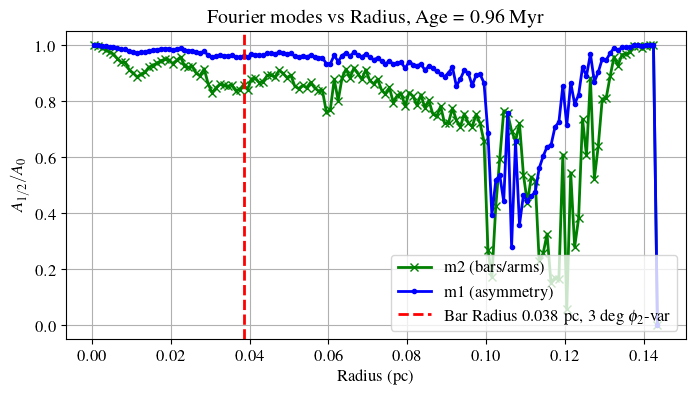

yt : [INFO     ] 2023-10-26 16:19:52,723 Parameters: current_time              = 21.953918346113
yt : [INFO     ] 2023-10-26 16:19:52,724 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:19:52,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:19:52,726 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:19:52,727 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:19:52,728 Parameters: current_redshift          = 19.166463445747
yt : [INFO     ] 2023-10-26 16:19:52,729 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:19:52,729 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:19:52,730 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:19:52,731 Parameters: hubble_constant           = 0.71


DD: DD0275, age: 0.96 Myr, m2 mean: 0.7838, m2 var: 0.2113, m1_avg: 0.8897, m1_var: 0.1686, Bar radius: 0.0385, Bar strength: 0.9161, m1 in bar region: 0.9782, phi_2_mean: 3.0849 deg, phi_2_var: 27.11394 deg 

ds =  DD0276


Parsing Hierarchy : 100%|██████████| 5885/5885 [00:00<00:00, 14453.68it/s]
yt : [INFO     ] 2023-10-26 16:19:53,344 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:26:13,904 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:26:13,932 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:26:13,940 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:26:14,821 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:26:15,311 Making a fixed resolution buffer of (radius) 2048 by 2048


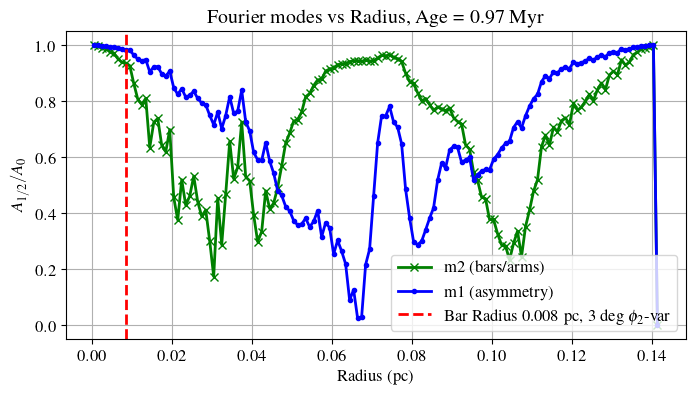

yt : [INFO     ] 2023-10-26 16:26:44,545 Parameters: current_time              = 21.955035250113
yt : [INFO     ] 2023-10-26 16:26:44,546 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:26:44,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:26:44,548 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:26:44,549 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:26:44,550 Parameters: current_redshift          = 19.165779420746
yt : [INFO     ] 2023-10-26 16:26:44,551 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:26:44,551 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:26:44,552 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:26:44,553 Parameters: hubble_constant           = 0.71


DD: DD0276, age: 0.97 Myr, m2 mean: 0.7052, m2 var: 0.2320, m1_avg: 0.6898, m1_var: 0.2588, Bar radius: 0.0085, Bar strength: 0.9758, m1 in bar region: 0.9939, phi_2_mean: -20.3328 deg, phi_2_var: 45.00211 deg 

ds =  DD0277


Parsing Hierarchy : 100%|██████████| 5768/5768 [00:00<00:00, 7816.14it/s] 
yt : [INFO     ] 2023-10-26 16:26:45,465 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:33:52,563 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:33:52,609 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:33:52,616 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:33:53,536 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:33:54,930 Making a fixed resolution buffer of (radius) 2048 by 2048


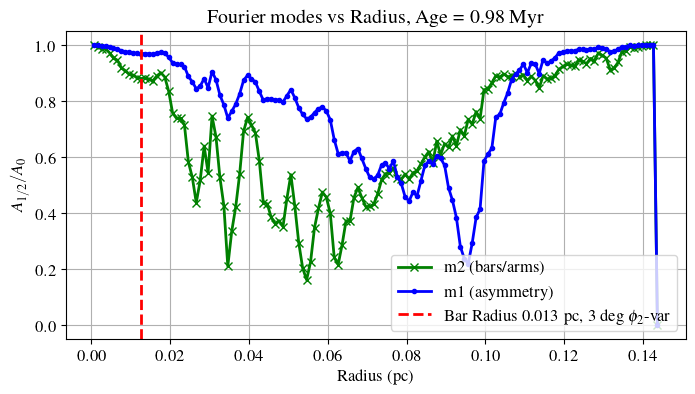

yt : [INFO     ] 2023-10-26 16:34:10,341 Parameters: current_time              = 21.956152154113
yt : [INFO     ] 2023-10-26 16:34:10,342 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:34:10,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:34:10,344 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:34:10,345 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:34:10,346 Parameters: current_redshift          = 19.165095453743
yt : [INFO     ] 2023-10-26 16:34:10,347 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:34:10,348 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:34:10,349 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:34:10,349 Parameters: hubble_constant           = 0.71


DD: DD0277, age: 0.98 Myr, m2 mean: 0.6927, m2 var: 0.2393, m1_avg: 0.7885, m1_var: 0.2085, Bar radius: 0.0126, Bar strength: 0.9449, m1 in bar region: 0.9860, phi_2_mean: 30.8901 deg, phi_2_var: 36.48392 deg 

ds =  DD0278


Parsing Hierarchy : 100%|██████████| 5670/5670 [00:00<00:00, 9332.38it/s] 
yt : [INFO     ] 2023-10-26 16:34:11,166 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:39:40,384 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:39:40,449 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:39:40,457 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:39:41,595 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:39:42,066 Making a fixed resolution buffer of (radius) 2048 by 2048


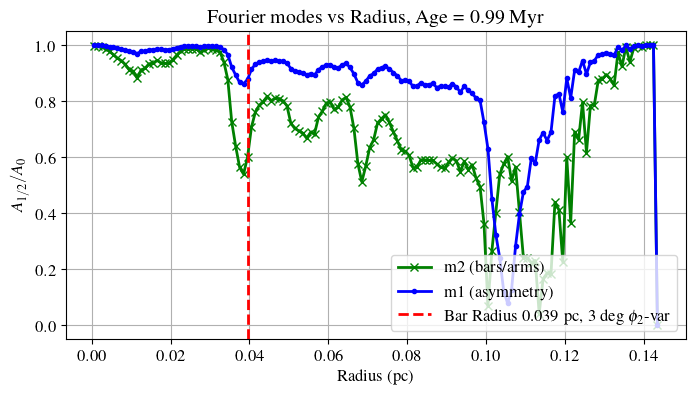

yt : [INFO     ] 2023-10-26 16:39:50,177 Parameters: current_time              = 21.957269058113
yt : [INFO     ] 2023-10-26 16:39:50,178 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:39:50,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:39:50,180 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:39:50,181 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:39:50,182 Parameters: current_redshift          = 19.164411544728
yt : [INFO     ] 2023-10-26 16:39:50,183 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:39:50,184 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:39:50,185 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:39:50,185 Parameters: hubble_constant           = 0.71


DD: DD0278, age: 0.99 Myr, m2 mean: 0.7127, m2 var: 0.2359, m1_avg: 0.8628, m1_var: 0.1951, Bar radius: 0.0395, Bar strength: 0.9205, m1 in bar region: 0.9779, phi_2_mean: 7.9615 deg, phi_2_var: 27.87731 deg 

ds =  DD0279


Parsing Hierarchy : 100%|██████████| 5762/5762 [00:00<00:00, 11786.02it/s]
yt : [INFO     ] 2023-10-26 16:39:50,851 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:46:59,164 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:46:59,192 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:46:59,208 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:47:00,073 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:47:00,561 Making a fixed resolution buffer of (radius) 2048 by 2048


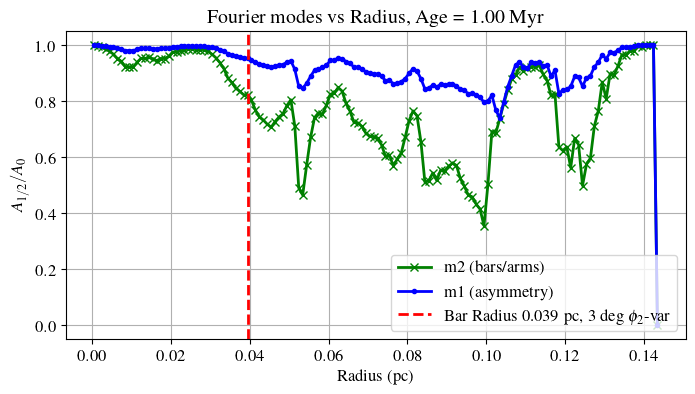

yt : [INFO     ] 2023-10-26 16:47:07,586 Parameters: current_time              = 21.958385962113
yt : [INFO     ] 2023-10-26 16:47:07,587 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-26 16:47:07,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-26 16:47:07,589 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-10-26 16:47:07,590 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-26 16:47:07,591 Parameters: current_redshift          = 19.163727693694
yt : [INFO     ] 2023-10-26 16:47:07,592 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-10-26 16:47:07,592 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-10-26 16:47:07,593 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-10-26 16:47:07,594 Parameters: hubble_constant           = 0.71


DD: DD0279, age: 1.00 Myr, m2 mean: 0.7787, m2 var: 0.1795, m1_avg: 0.9178, m1_var: 0.0978, Bar radius: 0.0394, Bar strength: 0.9480, m1 in bar region: 0.9866, phi_2_mean: -5.8643 deg, phi_2_var: 29.27321 deg 

ds =  DD0280


Parsing Hierarchy : 100%|██████████| 5622/5622 [00:00<00:00, 15351.29it/s]
yt : [INFO     ] 2023-10-26 16:47:08,131 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-10-26 16:54:40,321 xlim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:54:40,343 ylim = -0.000003 0.000003
yt : [INFO     ] 2023-10-26 16:54:40,347 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-26 16:54:41,370 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-10-26 16:54:42,092 Making a fixed resolution buffer of (radius) 2048 by 2048


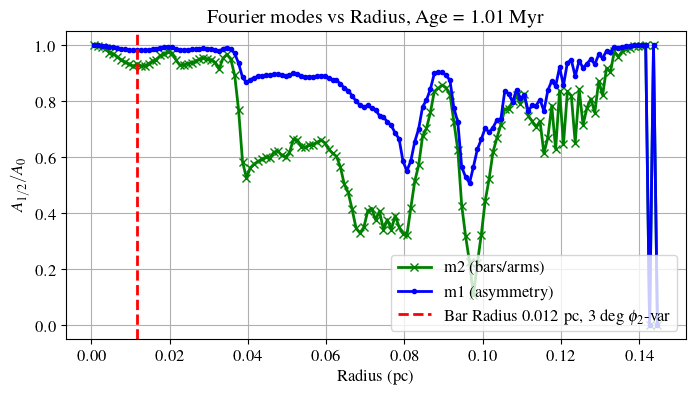

DD: DD0280, age: 1.01 Myr, m2 mean: 0.7141, m2 var: 0.2341, m1_avg: 0.8615, m1_var: 0.1569, Bar radius: 0.0116, Bar strength: 0.9649, m1 in bar region: 0.9911, phi_2_mean: -12.5817 deg, phi_2_var: 39.64302 deg 



In [19]:
with open("bar_strengths_and_phase_angle_width_pc_0.2.txt", "a") as f:
    for d, ds in enumerate(ds_list):
        width_pc = 0.2
        
        # Load dataset
        sim_label = tidy_data_labels(extract_simulation_name(ds.directory))
        sim_label = sim_label.replace("-2", "")
        sim_label = sim_label.replace("RS", "")
        if d == 0:
            #print("Simulation: {}, DD: {}, Age: {:.2f}, Sliceplot width: {} pc".format(sim_label, extract_dd_segment(ds.directory), age, width_pc))
            f.write("Simulation: {} , width_pc: {}, phi2 angle limit: 3 deg\n".format(sim_label, width_pc))

        # Grab bh properties and define center, width, and resolution of sliceplots
        ss_pos, ss_mass, ss_age = ss_properties(ds, velocity=False)
        age = ss_age[0]/1e6 * yt.units.Myr
        center = ss_pos
        npixels = 2048

        # Obtain angular momentum vector from a small disk and define a larger disk for plotting
        disc_r_pc = disc_h_pc = 0.01
        dx = ds.index.get_smallest_dx().in_units('cm')
        _, L = _make_disk_L(ds, center, disc_r_pc, disc_h_pc)
        vecs = ortho_find(L)
        dir = vecs[0]
        north = vecs[1]
        disc_r_pc_big = disc_h_pc_big = 0.6
        disk = ds.disk(center, L, disc_r_pc_big, disc_h_pc_big)
        density, radius_pc = field_from_sliceplot("density", ds, disk, center, width_pc, north, dir, npixels=npixels, radius=True)
        surface_density = density * dx # g/cm^2

        # unpack bar strength function
        # Determine maximum and minimum radii from data
        r_min = np.min(radius_pc).value
        r_max = np.max(radius_pc).value
        
        # List of radii to define annular regions with thickness dr
        dr = 0.001
        radii = np.arange(r_min, r_max + dr, dr) # 73

        # area, density, theta values
        dV = dx**3
        densities = density
        theta = get_theta_values(surface_density)

        # Compute bar strength and phase angle variability across discrete annular regions
        bar_strengths = []
        m1_strengths = []
        phi_2_values = []
        phi_1_values = []

        # Loop through annular regions
        for r in radii:
            mask = (radius_pc >= r) & (radius_pc < r + dr)

            # Get densities and thetas for this annular region, where 0 < theta < 2pi
            masked_densities = densities[mask]
            theta_2d = np.tile(theta, (densities.shape[0], 1))
            masked_theta = theta_2d[mask]

            # Compute the mass-equivalent for each cell in this region
            mass_equivalent = masked_densities * dV

            # Compute a_2 and b_2 coefficients for m=2 mode
            a_2 = np.sum(mass_equivalent * np.cos(2 * masked_theta))
            b_2 = np.sum(mass_equivalent * np.sin(2 * masked_theta))

            # for the m = 1 mode
            a_1 = np.sum(mass_equivalent * np.cos(masked_theta))
            b_1 = np.sum(mass_equivalent * np.sin(masked_theta))

            # Compute A_0 for this region
            A_0 = np.sum(mass_equivalent)

            # Compute A_2 for this region
            A_2 = np.sqrt(a_2**2 + b_2**2)
            A_1 = np.sqrt(a_1**2 + b_1**2)

            # Compute the bar strength for this region
            bar_strength = A_2 / A_0 if A_0 != 0 else 0
            m1_strength = A_1 / A_0 if A_0 != 0 else 0
            bar_strengths.append(bar_strength)
            m1_strengths.append(m1_strength)

            # Compute the phase angle phi_2 for this region, where -90 < phi_2 < 90
            phi_2 = 0.5 * np.degrees(np.arctan2(b_2, a_2).value)
            phi_1 = np.degrees(np.arctan2(b_1, a_1).value)
            phi_2_values.append(phi_2)
            phi_1_values.append(phi_1)

        # Compute the standard deviation for phi_2 values across all annular regions
        phi_2_var = np.std(phi_2_values) # want this to be small < 3 deg
        phi_2_mean = np.mean(phi_2_values)
        m2_var = np.std(bar_strengths)
        m2_avg = np.mean(bar_strengths)
        m1_avg = np.mean(m1_strengths)
        m1_var = np.std(m1_strengths)

        # Find the radius of the bar feature
        bar_radius, i = find_bar_radius(phi_2_values, radii)
        bar_strength = np.mean(bar_strengths[:i])
        m1_strength = np.mean(m1_strengths[:i])

        # Plot bar strength vs radius
        plt.figure(figsize=(8, 4))
        plt.title('Fourier modes vs Radius, Age = {:.2f}'.format(age))
        plt.plot(radii, bar_strengths, label='m2 (bars/arms)', marker='x', color='green')
        plt.plot(radii, m1_strengths, label='m1 (asymmetry)', marker='.', color='blue')
        plt.axvline(bar_radius, color='red', linestyle='--', label=r'Bar Radius {:.3f} pc, 3 deg $\phi_2$-var'.format(bar_radius))
        plt.yscale('linear')
        plt.xlabel('Radius (pc)')
        plt.ylabel(r'$A_{1/2} / A_0$')
        plt.grid(True)
        plt.legend(loc='lower right')
        plt.savefig('bars/fourier_modes_vs_radius_{}_{}.png'.format(sim_label, extract_dd_segment(ds.directory)), dpi=300, bbox_inches='tight')
        plt.show()
        # Print and write to file
        info = "DD: {}, age: {:.2f}, m2 mean: {:.4f}, m2 var: {:.4f}, m1_avg: {:.4f}, m1_var: {:.4f}, Bar radius: {:.4f}, Bar strength: {:.4f}, m1 in bar region: {:.4f}, phi_2_mean: {:.4f} deg, phi_2_var: {:.5f} deg \n".format(extract_dd_segment(ds.directory), age, m2_avg, m2_var, m1_avg, m1_var, bar_radius, bar_strength, m1_strength, phi_2_mean, phi_2_var)
        print(info)
        f.write(info)